## Section 2: Natural Language Processing (NLP)

In section 1, we explore machine learning classification using traditional as well as deep learning methods utilizing transformer architecture. In this section, we will explore natural language processing (NLP) using the same transformer architecture. We will also explore the use of pre-trained models such as BERT in NLP.

In [ ]:
%mkdir models

In [ ]:
import pandas as pd
import warnings

# suppress warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# load the processed data
df = pd.read_csv('patients_with_ratings.csv')

# preview the data
display(df.head())

,patient_id,age,gender,medical_history,deterioration_label,timestamp,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,...,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia,fatigue_level,activity_level,mental_health_level
0,9b04b,65,Male,History of hypertension and type 2 diabetes.,True,2023-10-27T10:00:00Z,95.5,160.2,98.7,90.3,...,0,0,0,0,0,0,0,5,1,1
1,bffd5,45,Female,No significant medical history.,False,2023-10-27T10:05:00Z,70.2,120.5,75.0,98.5,...,0,0,0,0,0,0,0,2,4,4
2,fb35e,78,Male,"Chronic obstructive pulmonary disease (COPD), ...",True,2023-10-27T10:10:00Z,105.0,150.0,90.0,88.0,...,0,1,0,1,0,0,0,5,2,1
3,1e30e,30,Female,Mild asthma.,False,2023-10-27T10:15:00Z,65.0,110.0,70.0,99.0,...,0,0,0,0,1,0,0,1,5,4
4,116a4,55,Male,High cholesterol.,False,2023-10-27T10:20:00Z,75.5,135.0,85.0,97.0,...,0,0,0,0,0,0,0,3,3,3


## 1.1 Sentiment Analysis with BERT

In this section, we will explore the use of BERT for sentiment analysis on our dataset. To allow us to perform fine-tuning on BERT, we will make use of

### 1.1.1 Data Preprocessing

We will create classes for the questionnaire data so that it can be used for training and testing. We will train 3 different BERT models on fatigue, lifestyle as well as mental health.

In [ ]:
# Create labels for each column
def label_responses(df):
    # Copy the dataframe to avoid modifying the original
    df_label = df.copy()

    # Fatigue level: 1-2 positive, 3 neutral, 4-5 negative
    df_label['fatigue_label'] = df_label['fatigue_level'].apply(
        lambda x: 'Low Risk' if x in [1, 2] else ('Moderate Risk' if x == 3 else 'High Risk')
    )

    # Mental health level: 1-2 positive, 3 neutral, 4-5 negative
    df_label['mental_health_label'] = df_label['mental_health_level'].apply(
        lambda x: 'Low Risk' if x in [1, 2] else ('Moderate Risk' if x == 3 else 'High Risk')
    )

    return df_label

# Apply the labeling
df_with_label = label_responses(df)

# Display the original values and the new labels
display(df_with_label[['fatigue_level', 'fatigue_label',
                          'mental_health_level', 'mental_health_label']].head(10))

# Count the label distributions for each category
print("\nFatigue Label Distribution:")
print(df_with_label['fatigue_label'].value_counts())

print("\nMental Health Label Distribution:")
print(df_with_label['mental_health_label'].value_counts())

,fatigue_level,fatigue_label,mental_health_level,mental_health_label
0,5,High Risk,1,Low Risk
1,2,Low Risk,4,High Risk
2,5,High Risk,1,Low Risk
3,1,Low Risk,4,High Risk
4,3,Moderate Risk,3,Moderate Risk
5,4,High Risk,1,Low Risk
6,1,Low Risk,5,High Risk
7,5,High Risk,1,Low Risk
8,2,Low Risk,3,Moderate Risk
9,4,High Risk,1,Low Risk



Fatigue Label Distribution:
fatigue_label
Low Risk         513
High Risk        508
Moderate Risk    182
Name: count, dtype: int64

Mental Health Label Distribution:
mental_health_label
Low Risk         571
High Risk        460
Moderate Risk    172
Name: count, dtype: int64


In [ ]:
# construcut labelled dataset
df_label = df_with_label[['fatigue_label', 'mental_health_label']].copy()

# add describe_fatigue, describe_activity, and describe_mental_health columns from the original dataset
df_label['describe_fatigue_level'] = df['describe_fatigue_level']
df_label['describe_mental_health'] = df['describe_mental_health']

# preview the labelled dataset
display(df_label.head())

,fatigue_label,mental_health_label,describe_fatigue_level,describe_mental_health
0,High Risk,Low Risk,"Severe fatigue, difficulty getting out of bed.",Feeling anxious and low.
1,Low Risk,High Risk,Mild fatigue occasionally.,Generally good.
2,High Risk,Low Risk,Constant exhaustion.,Feeling down and worried.
3,Low Risk,High Risk,Not fatigued.,Good.
4,Moderate Risk,Moderate Risk,Moderate fatigue after work.,Stable.


We can see that the data is being properly prepared to be used for training and testing.

### 1.1.2 Model Training

In this section we will train 3 separate BERT models on A100 GPU.

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
!nvidia-smi

Sat May 24 01:58:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             41W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Function to prepare dataset for BERT
def prepare_data_for_bert(text_column, label_column, test_size=0.2):
    # Handle NaN values
    valid_indices = text_column.notna()
    texts = text_column[valid_indices].tolist()
    labels = label_column[valid_indices].tolist()

    # Convert string labels to integers
    label_map = {'Low Risk': 0, 'Moderate Risk': 1, 'High Risk': 2}
    labels = [label_map[label] for label in labels]

    # Split data into train and test sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, test_size=test_size, random_state=42, stratify=labels
    )

    return train_texts, test_texts, train_labels, test_labels

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and encode the texts
def encode_texts(texts, max_length=128):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Function to create torch dataset
def create_dataset(texts, labels):
    encodings = encode_texts(texts)
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    labels = torch.tensor(labels)
    return TensorDataset(input_ids, attention_mask, labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Function to train the model - modified to return evaluation data
def train_bert_model(train_dataset, val_dataset, num_labels=3, epochs=70):
    # Initialize the model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    ).to(device)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Set up optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        train_loss = 0
        train_progress = tqdm(train_loader, desc="Training")

        for batch in train_progress:
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            train_progress.set_description(f"Training (loss={loss.item():.4f})")

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training loss: {avg_train_loss:.4f}")

        # Validation phase for each epoch
        model.eval()
        val_loss = 0
        epoch_preds = []
        epoch_true = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                batch = tuple(b.to(device) for b in batch)
                input_ids, attention_mask, labels = batch

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                epoch_preds.extend(preds.cpu().numpy())
                epoch_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation loss: {avg_val_loss:.4f}")

    # Final evaluation phase
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation loss: {avg_val_loss:.4f}")

    # Return the model and evaluation results
    return model, true_labels, predictions, train_losses, val_losses

# Function to run classification of questionnaire responses for each aspect - modified to return evaluation results
def analyze_sentiment(df, text_column, label_column, model_name):
    print(f"\n--- {model_name} Classification of Questionnaire Responses Training ---\n")

    # Prepare data
    train_texts, test_texts, train_labels, test_labels = prepare_data_for_bert(
        df[text_column], df[label_column]
    )

    # Create datasets
    train_dataset = create_dataset(train_texts, train_labels)
    test_dataset = create_dataset(test_texts, test_labels)

    # Train model and get evaluation data
    model, true_labels, predictions, train_losses, val_losses = train_bert_model(train_dataset, test_dataset)

    # Save model
    model_path = f"models/bert_qr_{model_name.lower().replace(' ', '_')}"
    model.save_pretrained(model_path)
    print(f"Model saved to {model_path}")

    return model, model_name, true_labels, predictions, train_losses, val_losses

# Dictionary to store evaluation results
eval_results = {}
loss_history = {}

# Run sentiment analysis for each aspect
print("\n=== Training All Sentiment Analysis Models ===\n")

fatigue_model, fatigue_name, fatigue_true, fatigue_pred, fatigue_train_loss, fatigue_val_loss = analyze_sentiment(
    df_label,
    'describe_fatigue_level',
    'fatigue_label',
    'Fatigue'
)
eval_results['Fatigue'] = (fatigue_true, fatigue_pred)
loss_history['Fatigue'] = (fatigue_train_loss, fatigue_val_loss)

mental_health_model, mental_health_name, mental_health_true, mental_health_pred, mental_health_train_loss, mental_health_val_loss = analyze_sentiment(
    df_label,
    'describe_mental_health',
    'mental_health_label',
    'Mental Health'
)
eval_results['Mental Health'] = (mental_health_true, mental_health_pred)
loss_history['Mental Health'] = (mental_health_train_loss, mental_health_val_loss)


=== Training All Sentiment Analysis Models ===


--- Fatigue Classification of Questionnaire Responses Training ---



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/70


Training (loss=0.2035): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.5670


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.08it/s]


Validation loss: 0.3179
Epoch 2/70


Training (loss=0.0553): 100%|██████████| 60/60 [00:04<00:00, 12.12it/s]


Training loss: 0.2625


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.24it/s]


Validation loss: 0.1995
Epoch 3/70


Training (loss=0.0975): 100%|██████████| 60/60 [00:04<00:00, 12.06it/s]


Training loss: 0.1875


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.34it/s]


Validation loss: 0.2469
Epoch 4/70


Training (loss=0.0557): 100%|██████████| 60/60 [00:04<00:00, 12.12it/s]


Training loss: 0.1856


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.27it/s]


Validation loss: 0.2858
Epoch 5/70


Training (loss=0.0622): 100%|██████████| 60/60 [00:04<00:00, 12.08it/s]


Training loss: 0.1470


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.24it/s]


Validation loss: 0.2249
Epoch 6/70


Training (loss=0.0530): 100%|██████████| 60/60 [00:04<00:00, 12.09it/s]


Training loss: 0.1415


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.17it/s]


Validation loss: 0.2650
Epoch 7/70


Training (loss=0.0585): 100%|██████████| 60/60 [00:04<00:00, 12.07it/s]


Training loss: 0.1053


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.22it/s]


Validation loss: 0.2348
Epoch 8/70


Training (loss=0.0157): 100%|██████████| 60/60 [00:04<00:00, 12.06it/s]


Training loss: 0.0931


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.38it/s]


Validation loss: 0.2594
Epoch 9/70


Training (loss=0.0227): 100%|██████████| 60/60 [00:04<00:00, 12.08it/s]


Training loss: 0.0846


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.23it/s]


Validation loss: 0.2686
Epoch 10/70


Training (loss=0.0131): 100%|██████████| 60/60 [00:04<00:00, 12.09it/s]


Training loss: 0.0835


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.33it/s]


Validation loss: 0.3026
Epoch 11/70


Training (loss=0.0150): 100%|██████████| 60/60 [00:04<00:00, 12.12it/s]


Training loss: 0.0827


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.21it/s]


Validation loss: 0.2491
Epoch 12/70


Training (loss=0.0170): 100%|██████████| 60/60 [00:04<00:00, 12.10it/s]


Training loss: 0.0773


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.38it/s]


Validation loss: 0.2618
Epoch 13/70


Training (loss=0.3224): 100%|██████████| 60/60 [00:04<00:00, 12.09it/s]


Training loss: 0.0830


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.18it/s]


Validation loss: 0.2719
Epoch 14/70


Training (loss=0.0043): 100%|██████████| 60/60 [00:04<00:00, 12.10it/s]


Training loss: 0.0786


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.31it/s]


Validation loss: 0.2992
Epoch 15/70


Training (loss=0.0987): 100%|██████████| 60/60 [00:04<00:00, 12.11it/s]


Training loss: 0.0790


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.32it/s]


Validation loss: 0.2992
Epoch 16/70


Training (loss=0.2144): 100%|██████████| 60/60 [00:04<00:00, 12.11it/s]


Training loss: 0.0738


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.26it/s]


Validation loss: 0.3061
Epoch 17/70


Training (loss=0.1274): 100%|██████████| 60/60 [00:04<00:00, 12.09it/s]


Training loss: 0.0882


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.31it/s]


Validation loss: 0.2198
Epoch 18/70


Training (loss=0.2149): 100%|██████████| 60/60 [00:04<00:00, 12.10it/s]


Training loss: 0.0758


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.37it/s]


Validation loss: 0.2889
Epoch 19/70


Training (loss=0.0567): 100%|██████████| 60/60 [00:04<00:00, 12.09it/s]


Training loss: 0.0727


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.43it/s]


Validation loss: 0.2849
Epoch 20/70


Training (loss=0.0080): 100%|██████████| 60/60 [00:04<00:00, 12.09it/s]


Training loss: 0.0611


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.24it/s]


Validation loss: 0.2782
Epoch 21/70


Training (loss=0.0036): 100%|██████████| 60/60 [00:04<00:00, 12.09it/s]


Training loss: 0.0508


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.26it/s]


Validation loss: 0.3318
Epoch 22/70


Training (loss=0.1191): 100%|██████████| 60/60 [00:04<00:00, 12.09it/s]


Training loss: 0.0623


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.16it/s]


Validation loss: 0.3168
Epoch 23/70


Training (loss=0.0072): 100%|██████████| 60/60 [00:04<00:00, 12.11it/s]


Training loss: 0.0519


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.04it/s]


Validation loss: 0.2934
Epoch 24/70


Training (loss=0.0030): 100%|██████████| 60/60 [00:04<00:00, 12.09it/s]


Training loss: 0.0589


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.12it/s]


Validation loss: 0.3908
Epoch 25/70


Training (loss=0.0043): 100%|██████████| 60/60 [00:04<00:00, 12.09it/s]


Training loss: 0.0576


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.29it/s]


Validation loss: 0.3272
Epoch 26/70


Training (loss=0.0018): 100%|██████████| 60/60 [00:04<00:00, 12.07it/s]


Training loss: 0.0388


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.26it/s]


Validation loss: 0.3542
Epoch 27/70


Training (loss=0.0014): 100%|██████████| 60/60 [00:04<00:00, 12.12it/s]


Training loss: 0.0490


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.35it/s]


Validation loss: 0.3337
Epoch 28/70


Training (loss=0.0509): 100%|██████████| 60/60 [00:04<00:00, 12.10it/s]


Training loss: 0.0482


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.31it/s]


Validation loss: 0.3428
Epoch 29/70


Training (loss=0.0766): 100%|██████████| 60/60 [00:04<00:00, 12.09it/s]


Training loss: 0.0423


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.28it/s]


Validation loss: 0.3275
Epoch 30/70


Training (loss=0.0064): 100%|██████████| 60/60 [00:04<00:00, 12.10it/s]


Training loss: 0.0403


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.19it/s]


Validation loss: 0.3609
Epoch 31/70


Training (loss=0.0021): 100%|██████████| 60/60 [00:04<00:00, 12.08it/s]


Training loss: 0.0397


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.24it/s]


Validation loss: 0.3572
Epoch 32/70


Training (loss=0.2243): 100%|██████████| 60/60 [00:04<00:00, 12.11it/s]


Training loss: 0.0396


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.31it/s]


Validation loss: 0.3548
Epoch 33/70


Training (loss=0.1649): 100%|██████████| 60/60 [00:04<00:00, 12.08it/s]


Training loss: 0.0364


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.40it/s]


Validation loss: 0.3777
Epoch 34/70


Training (loss=0.0013): 100%|██████████| 60/60 [00:04<00:00, 12.10it/s]


Training loss: 0.0377


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.27it/s]


Validation loss: 0.3712
Epoch 35/70


Training (loss=0.0007): 100%|██████████| 60/60 [00:04<00:00, 12.06it/s]


Training loss: 0.0369


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.29it/s]


Validation loss: 0.3694
Epoch 36/70


Training (loss=0.0010): 100%|██████████| 60/60 [00:04<00:00, 12.10it/s]


Training loss: 0.0341


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.26it/s]


Validation loss: 0.3620
Epoch 37/70


Training (loss=0.0472): 100%|██████████| 60/60 [00:04<00:00, 12.08it/s]


Training loss: 0.0417


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.02it/s]


Validation loss: 0.3896
Epoch 38/70


Training (loss=0.0393): 100%|██████████| 60/60 [00:04<00:00, 12.11it/s]


Training loss: 0.0379


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.29it/s]


Validation loss: 0.3720
Epoch 39/70


Training (loss=0.0080): 100%|██████████| 60/60 [00:04<00:00, 12.08it/s]


Training loss: 0.0351


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.28it/s]


Validation loss: 0.3728
Epoch 40/70


Training (loss=0.1623): 100%|██████████| 60/60 [00:04<00:00, 12.13it/s]


Training loss: 0.0375


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.17it/s]


Validation loss: 0.3762
Epoch 41/70


Training (loss=0.0058): 100%|██████████| 60/60 [00:04<00:00, 12.09it/s]


Training loss: 0.0342


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.25it/s]


Validation loss: 0.3821
Epoch 42/70


Training (loss=0.0141): 100%|██████████| 60/60 [00:04<00:00, 12.10it/s]


Training loss: 0.0330


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.28it/s]


Validation loss: 0.3873
Epoch 43/70


Training (loss=0.0058): 100%|██████████| 60/60 [00:04<00:00, 12.10it/s]


Training loss: 0.0327


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.01it/s]


Validation loss: 0.3943
Epoch 44/70


Training (loss=0.0521): 100%|██████████| 60/60 [00:04<00:00, 12.04it/s]


Training loss: 0.0334


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.18it/s]


Validation loss: 0.3800
Epoch 45/70


Training (loss=0.0107): 100%|██████████| 60/60 [00:04<00:00, 12.09it/s]


Training loss: 0.0321


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.20it/s]


Validation loss: 0.3940
Epoch 46/70


Training (loss=0.0005): 100%|██████████| 60/60 [00:04<00:00, 12.07it/s]


Training loss: 0.0326


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.02it/s]


Validation loss: 0.4010
Epoch 47/70


Training (loss=0.1823): 100%|██████████| 60/60 [00:04<00:00, 12.06it/s]


Training loss: 0.0361


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.35it/s]


Validation loss: 0.3932
Epoch 48/70


Training (loss=0.0056): 100%|██████████| 60/60 [00:04<00:00, 12.04it/s]


Training loss: 0.0335


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.69it/s]


Validation loss: 0.4042
Epoch 49/70


Training (loss=0.0004): 100%|██████████| 60/60 [00:04<00:00, 12.04it/s]


Training loss: 0.0339


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.14it/s]


Validation loss: 0.3913
Epoch 50/70


Training (loss=0.0498): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0319


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.78it/s]


Validation loss: 0.4031
Epoch 51/70


Training (loss=0.0009): 100%|██████████| 60/60 [00:04<00:00, 12.01it/s]


Training loss: 0.0321


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.22it/s]


Validation loss: 0.4038
Epoch 52/70


Training (loss=0.0521): 100%|██████████| 60/60 [00:04<00:00, 12.06it/s]


Training loss: 0.0331


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.17it/s]


Validation loss: 0.4016
Epoch 53/70


Training (loss=0.1177): 100%|██████████| 60/60 [00:04<00:00, 12.03it/s]


Training loss: 0.0480


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.19it/s]


Validation loss: 0.3895
Epoch 54/70


Training (loss=0.0501): 100%|██████████| 60/60 [00:04<00:00, 12.06it/s]


Training loss: 0.0373


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.28it/s]


Validation loss: 0.3849
Epoch 55/70


Training (loss=0.0004): 100%|██████████| 60/60 [00:04<00:00, 12.05it/s]


Training loss: 0.0373


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.34it/s]


Validation loss: 0.4025
Epoch 56/70


Training (loss=0.0422): 100%|██████████| 60/60 [00:04<00:00, 12.05it/s]


Training loss: 0.0352


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.14it/s]


Validation loss: 0.3993
Epoch 57/70


Training (loss=0.0004): 100%|██████████| 60/60 [00:04<00:00, 12.06it/s]


Training loss: 0.0332


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.08it/s]


Validation loss: 0.4175
Epoch 58/70


Training (loss=0.0769): 100%|██████████| 60/60 [00:04<00:00, 12.04it/s]


Training loss: 0.0332


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.29it/s]


Validation loss: 0.4476
Epoch 59/70


Training (loss=0.1470): 100%|██████████| 60/60 [00:04<00:00, 12.04it/s]


Training loss: 0.0374


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.22it/s]


Validation loss: 0.4037
Epoch 60/70


Training (loss=0.0005): 100%|██████████| 60/60 [00:04<00:00, 12.03it/s]


Training loss: 0.0334


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.04it/s]


Validation loss: 0.4340
Epoch 61/70


Training (loss=0.0006): 100%|██████████| 60/60 [00:04<00:00, 12.07it/s]


Training loss: 0.0326


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.35it/s]


Validation loss: 0.4286
Epoch 62/70


Training (loss=0.0003): 100%|██████████| 60/60 [00:04<00:00, 12.03it/s]


Training loss: 0.0331


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.11it/s]


Validation loss: 0.4373
Epoch 63/70


Training (loss=0.0074): 100%|██████████| 60/60 [00:04<00:00, 12.06it/s]


Training loss: 0.0334


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.21it/s]


Validation loss: 0.4344
Epoch 64/70


Training (loss=0.0576): 100%|██████████| 60/60 [00:04<00:00, 12.04it/s]


Training loss: 0.0301


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.18it/s]


Validation loss: 0.4352
Epoch 65/70


Training (loss=0.0073): 100%|██████████| 60/60 [00:04<00:00, 12.04it/s]


Training loss: 0.0325


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.24it/s]


Validation loss: 0.4466
Epoch 66/70


Training (loss=0.0413): 100%|██████████| 60/60 [00:04<00:00, 12.05it/s]


Training loss: 0.0310


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.16it/s]


Validation loss: 0.4357
Epoch 67/70


Training (loss=0.0385): 100%|██████████| 60/60 [00:04<00:00, 12.04it/s]


Training loss: 0.0335


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.23it/s]


Validation loss: 0.4352
Epoch 68/70


Training (loss=0.0002): 100%|██████████| 60/60 [00:04<00:00, 12.05it/s]


Training loss: 0.0327


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.15it/s]


Validation loss: 0.4348
Epoch 69/70


Training (loss=0.0119): 100%|██████████| 60/60 [00:04<00:00, 12.02it/s]


Training loss: 0.0323


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.18it/s]


Validation loss: 0.4440
Epoch 70/70


Training (loss=0.0155): 100%|██████████| 60/60 [00:04<00:00, 12.06it/s]


Training loss: 0.0328


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.17it/s]


Validation loss: 0.4347


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.10it/s]


Validation loss: 0.4347
Model saved to models/bert_qr_fatigue

--- Mental Health Classification of Questionnaire Responses Training ---



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/70


Training (loss=0.1372): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.5993


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.85it/s]


Validation loss: 0.3105
Epoch 2/70


Training (loss=0.6887): 100%|██████████| 61/61 [00:05<00:00, 12.13it/s]


Training loss: 0.2615


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.74it/s]


Validation loss: 0.3142
Epoch 3/70


Training (loss=0.0616): 100%|██████████| 61/61 [00:05<00:00, 12.10it/s]


Training loss: 0.2007


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.97it/s]


Validation loss: 0.3256
Epoch 4/70


Training (loss=0.0121): 100%|██████████| 61/61 [00:05<00:00, 12.09it/s]


Training loss: 0.1636


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.85it/s]


Validation loss: 0.3224
Epoch 5/70


Training (loss=0.0197): 100%|██████████| 61/61 [00:05<00:00, 12.09it/s]


Training loss: 0.1349


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.64it/s]


Validation loss: 0.3660
Epoch 6/70


Training (loss=0.0106): 100%|██████████| 61/61 [00:05<00:00, 12.13it/s]


Training loss: 0.1307


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.95it/s]


Validation loss: 0.3632
Epoch 7/70


Training (loss=0.0143): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.1141


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.06it/s]


Validation loss: 0.4008
Epoch 8/70


Training (loss=0.1553): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.1248


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.85it/s]


Validation loss: 0.3779
Epoch 9/70


Training (loss=0.0025): 100%|██████████| 61/61 [00:05<00:00, 12.11it/s]


Training loss: 0.1163


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.78it/s]


Validation loss: 0.4581
Epoch 10/70


Training (loss=0.0113): 100%|██████████| 61/61 [00:05<00:00, 12.04it/s]


Training loss: 0.1031


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.43it/s]


Validation loss: 0.4530
Epoch 11/70


Training (loss=0.1493): 100%|██████████| 61/61 [00:05<00:00, 12.04it/s]


Training loss: 0.1127


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.48it/s]


Validation loss: 0.4351
Epoch 12/70


Training (loss=0.0455): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.0986


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.68it/s]


Validation loss: 0.4679
Epoch 13/70


Training (loss=0.0062): 100%|██████████| 61/61 [00:05<00:00, 12.09it/s]


Training loss: 0.0952


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.80it/s]


Validation loss: 0.4850
Epoch 14/70


Training (loss=0.0402): 100%|██████████| 61/61 [00:05<00:00, 12.15it/s]


Training loss: 0.0923


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.03it/s]


Validation loss: 0.5015
Epoch 15/70


Training (loss=0.0017): 100%|██████████| 61/61 [00:05<00:00, 12.16it/s]


Training loss: 0.0919


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.01it/s]


Validation loss: 0.5018
Epoch 16/70


Training (loss=0.0190): 100%|██████████| 61/61 [00:05<00:00, 12.14it/s]


Training loss: 0.0910


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.00it/s]


Validation loss: 0.5032
Epoch 17/70


Training (loss=0.0373): 100%|██████████| 61/61 [00:05<00:00, 12.13it/s]


Training loss: 0.0780


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.76it/s]


Validation loss: 0.5240
Epoch 18/70


Training (loss=0.0025): 100%|██████████| 61/61 [00:05<00:00, 12.14it/s]


Training loss: 0.0873


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.08it/s]


Validation loss: 0.5311
Epoch 19/70


Training (loss=0.0306): 100%|██████████| 61/61 [00:05<00:00, 12.20it/s]


Training loss: 0.0798


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.89it/s]


Validation loss: 0.5220
Epoch 20/70


Training (loss=0.0044): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0800


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.92it/s]


Validation loss: 0.5501
Epoch 21/70


Training (loss=0.1380): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0799


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.91it/s]


Validation loss: 0.5304
Epoch 22/70


Training (loss=0.0011): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0814


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.05it/s]


Validation loss: 0.5668
Epoch 23/70


Training (loss=0.0048): 100%|██████████| 61/61 [00:05<00:00, 12.19it/s]


Training loss: 0.0784


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.01it/s]


Validation loss: 0.5554
Epoch 24/70


Training (loss=0.0017): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0771


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.91it/s]


Validation loss: 0.5867
Epoch 25/70


Training (loss=0.0031): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0725


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.12it/s]


Validation loss: 0.5921
Epoch 26/70


Training (loss=0.0037): 100%|██████████| 61/61 [00:05<00:00, 12.16it/s]


Training loss: 0.0745


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.07it/s]


Validation loss: 0.5849
Epoch 27/70


Training (loss=0.0189): 100%|██████████| 61/61 [00:05<00:00, 12.18it/s]


Training loss: 0.0715


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.05it/s]


Validation loss: 0.5906
Epoch 28/70


Training (loss=0.0031): 100%|██████████| 61/61 [00:05<00:00, 12.18it/s]


Training loss: 0.0726


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.85it/s]


Validation loss: 0.5980
Epoch 29/70


Training (loss=0.0010): 100%|██████████| 61/61 [00:05<00:00, 12.15it/s]


Training loss: 0.0713


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.86it/s]


Validation loss: 0.6098
Epoch 30/70


Training (loss=0.0006): 100%|██████████| 61/61 [00:05<00:00, 12.18it/s]


Training loss: 0.0710


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.05it/s]


Validation loss: 0.6220
Epoch 31/70


Training (loss=0.0010): 100%|██████████| 61/61 [00:05<00:00, 12.19it/s]


Training loss: 0.0859


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.87it/s]


Validation loss: 0.5992
Epoch 32/70


Training (loss=0.0015): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0839


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.15it/s]


Validation loss: 0.5769
Epoch 33/70


Training (loss=0.0175): 100%|██████████| 61/61 [00:05<00:00, 12.18it/s]


Training loss: 0.0787


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.06it/s]


Validation loss: 0.5334
Epoch 34/70


Training (loss=0.0007): 100%|██████████| 61/61 [00:05<00:00, 12.15it/s]


Training loss: 0.0731


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.18it/s]


Validation loss: 0.5597
Epoch 35/70


Training (loss=0.0044): 100%|██████████| 61/61 [00:05<00:00, 12.19it/s]


Training loss: 0.0721


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.07it/s]


Validation loss: 0.5585
Epoch 36/70


Training (loss=0.0061): 100%|██████████| 61/61 [00:05<00:00, 12.16it/s]


Training loss: 0.0692


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.93it/s]


Validation loss: 0.5772
Epoch 37/70


Training (loss=0.0485): 100%|██████████| 61/61 [00:05<00:00, 12.16it/s]


Training loss: 0.0722


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.08it/s]


Validation loss: 0.5804
Epoch 38/70


Training (loss=0.0019): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0701


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.89it/s]


Validation loss: 0.6093
Epoch 39/70


Training (loss=0.0003): 100%|██████████| 61/61 [00:05<00:00, 12.19it/s]


Training loss: 0.0688


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.96it/s]


Validation loss: 0.6097
Epoch 40/70


Training (loss=0.0553): 100%|██████████| 61/61 [00:05<00:00, 12.18it/s]


Training loss: 0.0685


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.84it/s]


Validation loss: 0.6184
Epoch 41/70


Training (loss=0.0003): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0709


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.96it/s]


Validation loss: 0.6289
Epoch 42/70


Training (loss=0.1801): 100%|██████████| 61/61 [00:05<00:00, 12.18it/s]


Training loss: 0.0715


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.02it/s]


Validation loss: 0.6316
Epoch 43/70


Training (loss=0.0218): 100%|██████████| 61/61 [00:05<00:00, 12.14it/s]


Training loss: 0.0716


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.96it/s]


Validation loss: 0.6321
Epoch 44/70


Training (loss=0.0002): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0715


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.13it/s]


Validation loss: 0.6331
Epoch 45/70


Training (loss=0.0006): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0691


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.93it/s]


Validation loss: 0.6325
Epoch 46/70


Training (loss=0.0005): 100%|██████████| 61/61 [00:05<00:00, 12.19it/s]


Training loss: 0.0693


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.73it/s]


Validation loss: 0.6473
Epoch 47/70


Training (loss=0.4934): 100%|██████████| 61/61 [00:05<00:00, 12.16it/s]


Training loss: 0.0746


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.96it/s]


Validation loss: 0.6477
Epoch 48/70


Training (loss=0.0002): 100%|██████████| 61/61 [00:05<00:00, 12.19it/s]


Training loss: 0.0709


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.83it/s]


Validation loss: 0.6130
Epoch 49/70


Training (loss=0.2375): 100%|██████████| 61/61 [00:05<00:00, 12.16it/s]


Training loss: 0.0759


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.67it/s]


Validation loss: 0.6294
Epoch 50/70


Training (loss=0.0001): 100%|██████████| 61/61 [00:05<00:00, 12.19it/s]


Training loss: 0.0687


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.11it/s]


Validation loss: 0.6459
Epoch 51/70


Training (loss=0.0008): 100%|██████████| 61/61 [00:05<00:00, 12.19it/s]


Training loss: 0.0655


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.92it/s]


Validation loss: 0.6498
Epoch 52/70


Training (loss=0.0003): 100%|██████████| 61/61 [00:05<00:00, 12.18it/s]


Training loss: 0.0676


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.89it/s]


Validation loss: 0.6529
Epoch 53/70


Training (loss=0.0002): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0662


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.98it/s]


Validation loss: 0.6607
Epoch 54/70


Training (loss=0.0002): 100%|██████████| 61/61 [00:05<00:00, 12.14it/s]


Training loss: 0.0680


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.03it/s]


Validation loss: 0.6646
Epoch 55/70


Training (loss=0.0003): 100%|██████████| 61/61 [00:05<00:00, 12.16it/s]


Training loss: 0.0674


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.15it/s]


Validation loss: 0.6700
Epoch 56/70


Training (loss=0.0011): 100%|██████████| 61/61 [00:05<00:00, 12.19it/s]


Training loss: 0.0692


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.10it/s]


Validation loss: 0.6686
Epoch 57/70


Training (loss=0.0008): 100%|██████████| 61/61 [00:05<00:00, 12.18it/s]


Training loss: 0.0708


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.67it/s]


Validation loss: 0.6686
Epoch 58/70


Training (loss=0.0003): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0694


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.87it/s]


Validation loss: 0.6698
Epoch 59/70


Training (loss=0.3360): 100%|██████████| 61/61 [00:05<00:00, 12.18it/s]


Training loss: 0.0731


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.89it/s]


Validation loss: 0.6729
Epoch 60/70


Training (loss=0.0003): 100%|██████████| 61/61 [00:05<00:00, 12.15it/s]


Training loss: 0.0685


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.85it/s]


Validation loss: 0.6738
Epoch 61/70


Training (loss=0.0003): 100%|██████████| 61/61 [00:05<00:00, 12.18it/s]


Training loss: 0.0678


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.04it/s]


Validation loss: 0.6768
Epoch 62/70


Training (loss=0.0003): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0680


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.93it/s]


Validation loss: 0.6834
Epoch 63/70


Training (loss=0.0003): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0693


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.05it/s]


Validation loss: 0.7027
Epoch 64/70


Training (loss=0.1988): 100%|██████████| 61/61 [00:05<00:00, 12.19it/s]


Training loss: 0.0709


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.97it/s]


Validation loss: 0.6882
Epoch 65/70


Training (loss=0.0007): 100%|██████████| 61/61 [00:05<00:00, 12.16it/s]


Training loss: 0.0678


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.09it/s]


Validation loss: 0.6838
Epoch 66/70


Training (loss=0.1018): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0690


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.90it/s]


Validation loss: 0.6831
Epoch 67/70


Training (loss=0.0004): 100%|██████████| 61/61 [00:05<00:00, 12.20it/s]


Training loss: 0.0671


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.01it/s]


Validation loss: 0.6889
Epoch 68/70


Training (loss=0.0002): 100%|██████████| 61/61 [00:05<00:00, 12.17it/s]


Training loss: 0.0680


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.18it/s]


Validation loss: 0.6970
Epoch 69/70


Training (loss=0.0001): 100%|██████████| 61/61 [00:05<00:00, 12.19it/s]


Training loss: 0.0683


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.12it/s]


Validation loss: 0.6937
Epoch 70/70


Training (loss=0.0002): 100%|██████████| 61/61 [00:05<00:00, 12.15it/s]


Training loss: 0.0668


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.99it/s]


Validation loss: 0.6877


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.02it/s]


Validation loss: 0.6877
Model saved to models/bert_qr_mental_health


Fatigue model - Best epoch: 2 with validation loss: 0.1995
Mental Health model - Best epoch: 1 with validation loss: 0.3105


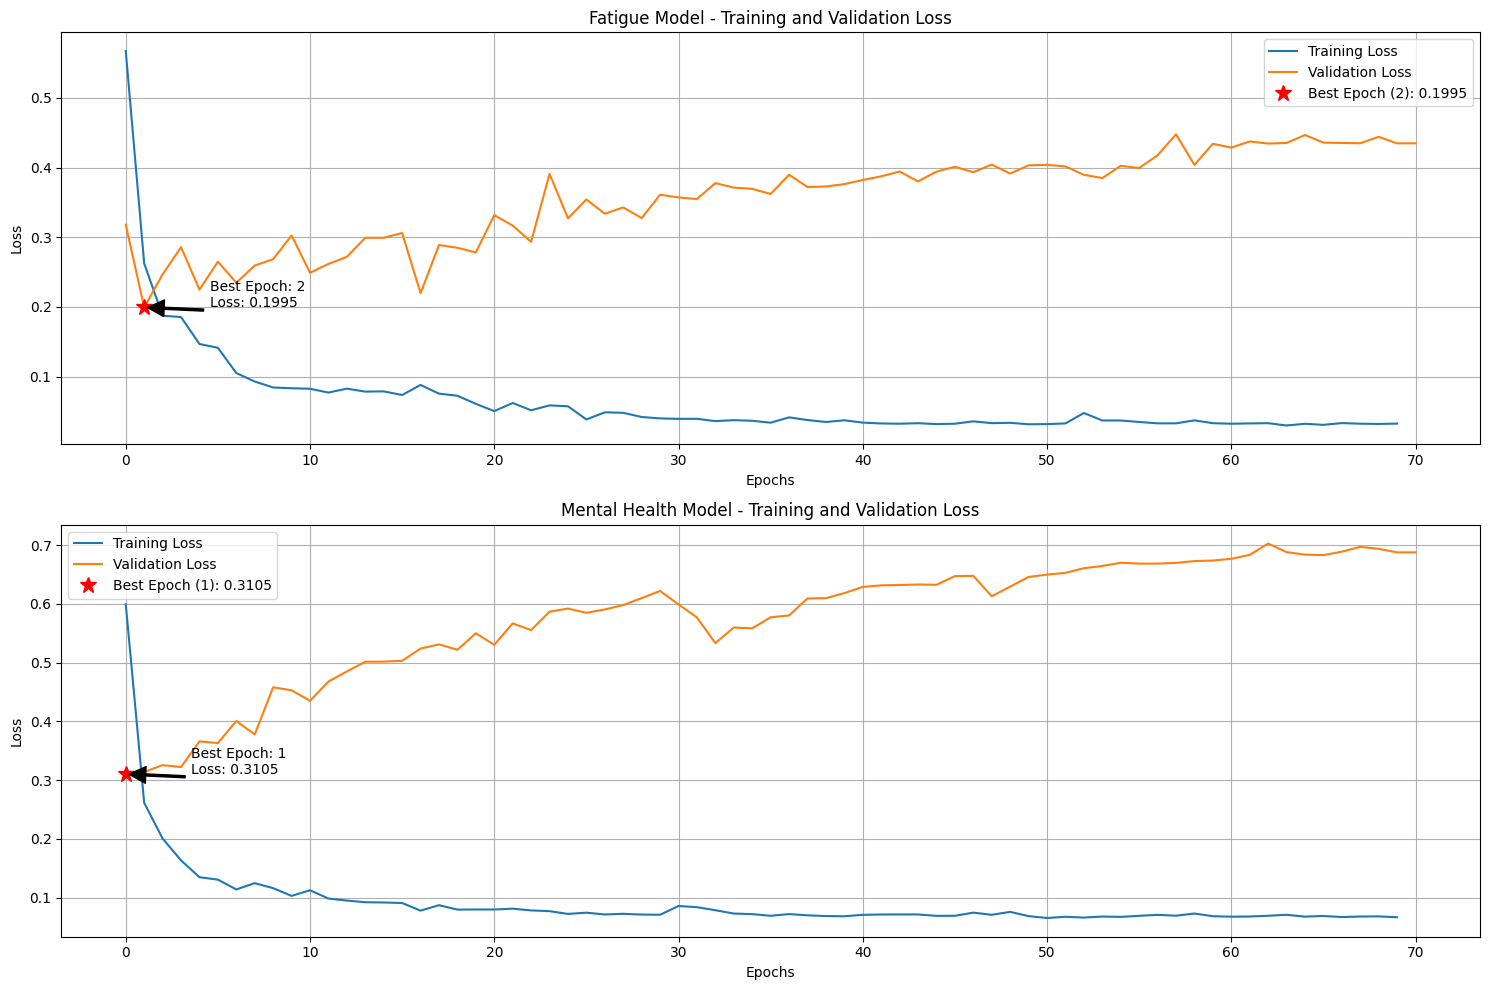

In [ ]:
# Plot training and validation loss for each model with best epoch highlighted
import matplotlib.pyplot as plt
import os
import numpy as np

os.makedirs('images', exist_ok=True)

plt.figure(figsize=(15, 10))

for i, (model_name, (train_losses, val_losses)) in enumerate(loss_history.items(), 1):
    plt.subplot(len(loss_history), 1, i)

    # Plot loss curves
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')

    # Find the best epoch (lowest validation loss)
    best_epoch = np.argmin(val_losses)
    best_val_loss = val_losses[best_epoch]

    # Highlight the best epoch with a star marker
    plt.plot(best_epoch, best_val_loss, 'r*', markersize=12,
             label=f'Best Epoch ({best_epoch+1}): {best_val_loss:.4f}')

    # Add text annotation for clarity - using offset to avoid overlapping
    # Calculate text position to avoid overlapping with the curve
    text_x = best_epoch + len(val_losses) * 0.05  # Offset by 5% of total epochs
    text_y = best_val_loss

    # Make sure text stays within plot boundaries
    text_x = min(text_x, len(val_losses) * 0.7)  # Keep within 70% of plot width

    plt.annotate(f'Best Epoch: {best_epoch+1}\nLoss: {best_val_loss:.4f}',
                xy=(best_epoch, best_val_loss),
                xytext=(text_x, text_y),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

    plt.title(f'{model_name} Model - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Print detailed information to verify
    print(f"{model_name} model - Best epoch: {best_epoch+1} with validation loss: {best_val_loss:.4f}")

plt.tight_layout()
plt.savefig('images/qr_loss_curves_with_best_epoch.png')
plt.show()

In [ ]:
# Display all evaluation reports after all models are trained
print("\n\n" + "="*70)
print("EVALUATION REPORTS FOR ALL CLASSIFICATION OF QUESTIONNAIRE RESPONSES MODELS")
print("="*70)

label_names = ['Low Risk', 'Moderate Risk', 'High Risk']
for model_name, (true_labels, predictions) in eval_results.items():
    print(f"\n{model_name} Model Evaluation:")
    print("-" * 40)
    print(classification_report(true_labels, predictions, target_names=label_names))
    print("\n")

import pickle
# Save the evaluation results to a pickle file
with open('models/qr_eval_results.pkl', 'wb') as f:
    pickle.dump(eval_results, f)



EVALUATION REPORTS FOR ALL CLASSIFICATION OF QUESTIONNAIRE RESPONSES MODELS

Fatigue Model Evaluation:
----------------------------------------
               precision    recall  f1-score   support

     Low Risk       0.97      0.92      0.95       103
Moderate Risk       0.78      0.80      0.79        35
    High Risk       0.94      0.98      0.96       102

     accuracy                           0.93       240
    macro avg       0.90      0.90      0.90       240
 weighted avg       0.93      0.93      0.93       240




Mental Health Model Evaluation:
----------------------------------------
               precision    recall  f1-score   support

     Low Risk       0.96      0.96      0.96       114
Moderate Risk       0.63      0.54      0.58        35
    High Risk       0.88      0.91      0.89        92

     accuracy                           0.88       241
    macro avg       0.82      0.81      0.81       241
 weighted avg       0.88      0.88      0.88       241





In [ ]:
# zip the models directory
!zip -r models.zip models
!zip -r images.zip images

# download from colab
from google.colab import files
files.download('models.zip')

  adding: models/ (stored 0%)
  adding: models/qr_eval_results.pkl (deflated 96%)
  adding: models/bert_qr_fatigue/ (stored 0%)
  adding: models/bert_qr_fatigue/model.safetensors (deflated 7%)
  adding: models/bert_qr_fatigue/config.json (deflated 51%)
  adding: models/.ipynb_checkpoints/ (stored 0%)
  adding: models/bert_qr_mental_health/ (stored 0%)
  adding: models/bert_qr_mental_health/model.safetensors (deflated 7%)
  adding: models/bert_qr_mental_health/config.json (deflated 51%)
  adding: images/ (stored 0%)
  adding: images/loss_curves_with_best_epoch.png (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>